# Modelos Bayesianos

Aplicar um modelo estatístico a um conjunto de dados significa interpretá-lo como um conjunto de realizações de um experimento randomizado. Isso permite associar o conjunto de dados a uma distribuição de probabilidades, e então utilizar o arcabouço de técnicas da estatística para executar análises automatizadas. Neste caderno, utilizaremos o Teorema de Bayes para executar diversas análises em nosso conjunto de dados.

# Objetivos

Ao final desta iteração, o aluno será capaz de:
* Entender o conceito de *modelo gerador*
* Entender o conceito de *aprendizado não-supervisionado*
* Aplicar modelos de misturas de Gaussianas em contextos supervisionados e não-supervisionados
* Comparar o desempenho de sistemas

In [1]:
# Inicializacao
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

# Abrindo conjunto de dados
import csv
with open("biometria.csv", 'rb') as f:
    dados = list(csv.reader(f))
    
rotulos_volei = [d[0] for d in dados[1:-1] if d[0] is 'V']
rotulos_futebol = [d[0] for d in dados[1:-1] if d[0] is 'F']
altura_volei = [[float(d[1])] for d in dados[1:-1] if d[0] is 'V']
altura_futebol = [[float(d[1])] for d in dados[1:-1] if d[0] is 'F']
peso_volei = [[float(d[2])] for d in dados[1:-1] if d[0] is 'V']
peso_futebol = [[float(d[2])] for d in dados[1:-1] if d[0] is 'F']


# Teorema de Bayes

O Teorema de Bayes, tradicionalmente conhecida na estatística, determina que:

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

A dedução do teorema não é tão importante quanto a sua interpretação. Se $A$ é um rótulo (não-observável) e $B$ é um conjunto de propriedades de um elemento, então temos um caso bastante interessante: a probabilidade de observar $A$ dado que o elemento pertence a uma classe $B$ é determinada pela probabilidade de encontrar a observação $B$ dada uma classe $A$, da probabilidade de encontrar a classe $A$ no conjunto-universo e da probabilidade de encontrar a observação $B$ no conjunto universo. Em outras palavras:

$$\mbox{Expectativa A Posteriori} = P(\mbox{Rótulo | Observação}) \propto \mbox{Verossimilhança} \times \mbox{Expectativa A Priori}.$$

Isso significa que, se formos capazes de estimar a distribuição dos dados $B$ em um conjunto $A$ (ou seja, $P(B|A)$), podemos estimar $P(A|B)$ como uma medida da força da hipótese de se atribuir o rótulo $A$ à observação $B$. Para o caso que temos trabalhado, de esportistas, temos:

$$P(\mbox{Esporte} | \mbox{Altura, Peso}) \propto P(\mbox{Altura, Peso}|\mbox{Esporte})P(\mbox{Esporte}).$$

# Misturas de Gaussianas

Uma forma possível de estimar $P(\mbox{Altura, Peso}|\mbox{Esporte})$ é utilizar dados rotulados e uma distribuição escolhida. Uma idéia bastante comum é assumir uma distribuição Gaussiana com desvio-padrão $\sigma$ e média $\mu$, de tal forma que:

$$G(x, \mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}} e^{ - \frac{1}{2} (\frac{x-\mu}{\sigma})^2}.$$

Uma Gaussiana pode ser um modelo interessante para diversas distribuições, mas nem sempre para todas. Um modelo mais avançado é a mistura de Gaussianas, que representa uma distribuição que é uma soma ponderada de $M$ distribuições Gaussianas:

$$S(x, \Theta) = \sum_{m=1}^M a_m G(x, \mu_m, \sigma_m),$$
onde $\Theta$ representa o conjunto de todos os parâmetros do modelo e $\sum_{m=1}^M a_m = 1$.

O modelo de mistura de Gaussianas (*Gaussian Mixture Model*, GMM) pode se adaptar a um conjunto de dados através de um algoritmo chamado Maximização de Expectativa (*Expectation Maximization*, EM). O algoritmo EM é um algoritmo iterativo que estima novos parâmetros $\Theta'$ à partir do conjunto de parâmetros atuais do modelo e de um conjunto de dados não-rotulados. Os novos parâmetros são estimados de forma que $S(x, \Theta') > S(x, \Theta)$, isto é, maximizando a probabilidade de que os dados sejam gerados pelo modelo.

Assim, podemos estimar $P(B|A)$ assumindo um modelo gerativo tipo GMM e então usando o algoritmo EM em dados de treino.

# Decisão de Máxima Verossimilhança

A decisão de Máxima Verossimilhança (*Maximum Likelihood*, ML) desconsidera a probabilidade de cada classe *a priori*. Esse tipo de estimador é importante em situações em que a estimativa de $P(\mbox{Rótulo})$ não é confiável ou não é relevante. Um possível exemplo é um algoritmo que verificará, através de dados, se um paciente é portador de uma determinada doença rara.

Se a probabilidade *a priori* for levada em consideração, o índice de falsos negativos será muito alto, uma vez que espera-se que apenas uma fração muito pequena da população seja portadora da doença. Em diversos casos, um estimador com menor índice de erros simplesmente escolhe a classe mais frequente, independente de outros fatores. Porém, esse índice *a priori* não é relevante para o paciente em questão: a probabilidade diz respeito à probabilidade de um indivíduo aleatório da população ser portador da doença, e não à probabilidade relacionada a aquele indivíduo específico.

A decisão ML consiste em estimar modelos de $P(\mbox{Observação | Rótulo})$ para cada classe, e então assumir como resposta do sistema a classe de maior probabilidade. Assim, temos:

In [2]:
from sklearn import mixture
from sklearn.cross_validation import train_test_split

def treinamento_GMM_ML(train_size=0.3, n_components=2):
    # Separar dados adequadamente
    dados_treino, dados_teste, rotulos_treino, rotulos_teste =\
        train_test_split(altura_volei + altura_futebol, rotulos_volei + rotulos_futebol, train_size=train_size)

    treino_futebol = [dados_treino[i] for i in xrange(len(dados_treino)) if rotulos_treino[i] == 'F']    
    treino_volei = [dados_treino[i] for i in xrange(len(dados_treino)) if rotulos_treino[i] == 'V']

    # Especificar parametros da mistura
    g1 = mixture.GMM(n_components=n_components)
    g2 = mixture.GMM(n_components=n_components)

    # Treinar modelo GMM
    g1.fit(treino_futebol)
    g2.fit(treino_volei)

    # Executar modelos sobre conjunto de teste
    p_futebol = g1.score(dados_teste)
    p_volei = g2.score(dados_teste)

    # Verificar qual modelo mais provavelmente gerou os dados de teste
    x = []
    for i in xrange(len(dados_teste)):
        if p_futebol[i] > p_volei[i]:
            x.append('F')
        else:
            x.append('V')

    # Verificar quantidade de acertos
    acertos = 0.0
    for i in xrange(len(x)):
        if x[i] == rotulos_teste[i]:
            acertos += 1
    acertos *= 100.0/float(len(x))
    
    return acertos

print "Acertos:", treinamento_GMM_ML(), "%"

 Acertos:

NameError: global name 'altura_volei' is not defined

Podemos verificar a estabilidade do modelo para diferentes tamanhos de conjunto de treino de forma semelhante a que fizemos no caso de KNN:


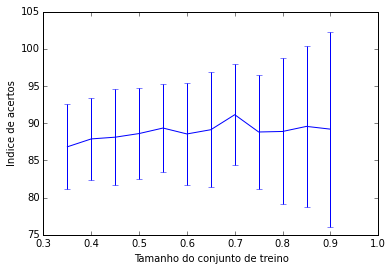

In [3]:
# Parametros para executar busca exaustiva
train_size_min = 0.35
train_size_max = 0.95
train_size_step = 0.05

# Numero de iteracoes para cada tamanho de conjunto de treino
n_iter = 100

# Listas que armazenarao os resultados
steps = []
medias = []
variancias = []

train_size_atual = train_size_min
while train_size_atual <= train_size_max: # para cada tamanho do conjunto de treino
    acertos = []
    for k in xrange(n_iter): # para cada iteracao do processo Monte Carlo
        dados_treino, dados_teste, rotulos_treino, rotulos_teste =\
            train_test_split(altura_volei + altura_futebol, rotulos_volei + rotulos_futebol, train_size=train_size_atual)
            
        score = treinamento_GMM_ML(train_size=train_size_atual, n_components=2)
        acertos.append(score)
    
    steps.append(train_size_atual)
    medias.append(np.mean(np.array(acertos)))
    variancias.append(np.std(np.array(acertos)))
    
    train_size_atual += train_size_step


plt.figure();
plt.errorbar(steps, medias, yerr=variancias);
plt.ylabel('Indice de acertos');
plt.xlabel('Tamanho do conjunto de treino');

# Classificador Bayesiano
    
Embora o classificador ML seja bastante relevante em diversas aplicações, é possível que as probabilidades *a priori* sejam importantes em determinados problemas. Quando o resultado *para uma população* é mais importante que o resultado para cada indivíduo, o critério Bayesiano é mais adequado. Um possível problema é o de estimar o número de alunos que irão reprovar uma disciplina tomando por base seus históricos: neste caso, a probabilidade *a priori* de um aluno ser reprovado (medido pelo histórico de reprovações da disciplina/professor) é relevante.

Neste caso, estimaremos a probabilidade *a posteriori* para cada uma das classes, ou seja:

$$P_{\mbox{posteriori}} = P(\mbox{Observação | Rótulo}) \times P(\mbox{Rótulo})$$

Veja que a probabilidade condicional - a verossimilhança - pode ser estimada utilizando o algoritmo EM, ao passo que a probabilidade *a priori* pode ser estimada verificando a frequência de cada rótulo no conjunto de teste.

Então, escolheremos a classe com maior probabilidade *a posteriori*. Então, nossa função de estimativa pode ser modificada para:

In [4]:
import math

def treinamento_GMM_Bayesiano(train_size=0.3, n_components=2):
    # Separar dados adequadamente
    dados_treino, dados_teste, rotulos_treino, rotulos_teste =\
        train_test_split(altura_volei + altura_futebol, rotulos_volei + rotulos_futebol, train_size=train_size)

    treino_futebol = [dados_treino[i] for i in xrange(len(dados_treino)) if rotulos_treino[i] == 'F']    
    treino_volei = [dados_treino[i] for i in xrange(len(dados_treino)) if rotulos_treino[i] == 'V']

    # Especificar parametros da mistura
    g1 = mixture.GMM(n_components=n_components)
    g2 = mixture.GMM(n_components=n_components)

    # Treinar modelo GMM
    g1.fit(treino_futebol)
    g2.fit(treino_volei)
    
    # Treino das probabilidades a priori
    prior_futebol = len([rotulo for rotulo in rotulos_treino if rotulo == 'F']) / float(len(rotulos_treino))
    prior_volei = len([rotulo for rotulo in rotulos_treino if rotulo == 'V']) / float(len(rotulos_treino))
    
    # Executar modelos sobre conjunto de teste
    p_futebol = g1.score(dados_teste) + math.log(prior_futebol)
    p_volei = g2.score(dados_teste) + math.log(prior_volei)

    # Verificar qual modelo mais provavelmente gerou os dados de teste
    x = []
    for i in xrange(len(dados_teste)):
        if p_futebol[i] > p_volei[i]:
            x.append('F')
        else:
            x.append('V')

    # Verificar quantidade de acertos
    acertos = 0.0
    for i in xrange(len(x)):
        if x[i] == rotulos_teste[i]:
            acertos += 1
    acertos *= 100.0/float(len(x))
    
    return acertos

print "Acertos:", treinamento_GMM_Bayesiano(), "%"

Acertos: 83.8709677419 %


O estimador Bayesiano é um estimador de máxima probabilidade *a posteriori*, por isso é também chamado de estimador *Maximum a Posteriori* (MAP). O critério **MAP** minimiza a probabilidade de erro teórico do estimador. Embora esse seja um resultado relevante, também é importante considerar que a estimativa das probabilidades envolvidas pode não ser sempre ótima.

Em comparação com o estimador ML, o estimador MAP é capaz de atingir resultados teóricos melhores. Ao mesmo tempo, tem mais parâmetros que devem ser estimados, o que significa que precisa de mais dados para ser treinado adequadamente. Por fim, ambos os estimadores são adequados para aplicações ligeiramente diferentes.

# Comparando ML e MAP

Neste momento, é importante entender como comparar dois algoritmos de classificação. Vamos executar novamente o procedimento de teste Monte Carlo para o algoritmo MAP, e então mostrar sua curva de desempenho junto à de ML, como segue.

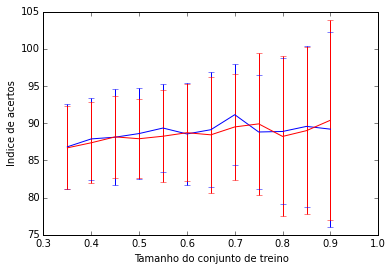

In [5]:
# Parametros para executar busca exaustiva
train_size_min = 0.35
train_size_max = 0.95
train_size_step = 0.05

# Numero de iteracoes para cada tamanho de conjunto de treino
n_iter = 100

# Listas que armazenarao os resultados
steps1 = []
medias1 = []
variancias1 = []

train_size_atual = train_size_min
while train_size_atual <= train_size_max: # para cada tamanho do conjunto de treino
    acertos = []
    for k in xrange(n_iter): # para cada iteracao do processo Monte Carlo
        dados_treino, dados_teste, rotulos_treino, rotulos_teste =\
            train_test_split(altura_volei + altura_futebol, rotulos_volei + rotulos_futebol, train_size=train_size_atual)
            
        score = treinamento_GMM_ML(train_size=train_size_atual, n_components=2)
        acertos.append(score)
    
    steps1.append(train_size_atual)
    medias1.append(np.mean(np.array(acertos)))
    variancias1.append(np.std(np.array(acertos)))
    
    train_size_atual += train_size_step


plt.figure();
plt.errorbar(steps, medias, yerr=variancias);
plt.errorbar(steps1, medias1, yerr=variancias1, color='red');
plt.ylabel('Indice de acertos');
plt.xlabel('Tamanho do conjunto de treino');

Veja que, embora MAP tenha uma possibilidade teórica de conseguir um erro menor que ML, seu erro médio é bastante semelhante. A variância do erro também apresenta um comportamento semelhante, aumentando à medida que o conjunto de treino aumenta. Essa variância não decorre de uma degradação do modelo, mas sim da diminuição do conjunto de testes: com a diminuição do número de pontos de teste, observa-se também o aumento do impacto dos pontos que geram classificações erradas.

# Classificação não-supervisionada

Em nosso algoritmo de classificação, temos adotado o paradigma de treinar classificadores de forma *supervisionada*, ou seja, fornecendo a ele exemplos rotulados. Porém, há situações em que queremos fornecer apenas exemplos *não-rotulados* ao nosso sistema. Dados rotulados podem ser difíceis de obter ou simplesmente não estar presentes em quantidade suficiente.

Neste caso, é necessário utilizar um algoritmo de treino que não dependa dos rótulos fornecidos na etapa de treino. O algoritmo EM, por exemplo, funciona de forma não-supervisionada, pois busca aumentar a probabilidade de que os dados sejam gerados por um modelo e não usa nenhuma informação além dos próprios vetores de características dos dados. Para que um algoritmo não-supervisionado funcione, é preciso que o seu funcionamento reflita, de alguma forma, o comportamento dos dados.

Para o nosso conjunto de dados, poderíamos adotar uma idéia simples, porém promissora. Se todos os pontos relativos à altura dos jogadores forem modelados por uma mistura de duas Gaussianas, seria provável que uma gaussiana se concentrasse nos jogadores de vôlei (mais altos) e outra nos jogadores de futebol (mais baixos). Nesse caso, poderíamos verificar qual das Gaussianas mais provavelmente gerou cada um dos pontos de dados, e, assim, associar cada ponto a um rótulo (vôlei para a Gaussiana de média mais alta, e futebol para a Gaussiana de média mais baixa).

O treinamento não-supervisionado tem a desvantagem de não receber dados rotulados, e, portanto, poder contar com menos informações. Em contrapartida, é possível que receba uma quantidade de dados maior, já que gerar rótulos nem sempre é simples. Assim, podemos escrever o algoritmo:

In [6]:
def treinamento_GMM_nao_supervisionado():
    # Especificar parametros da mistura
    g = mixture.GMM(n_components=2)

    # Treinar modelo GMM
    g.fit(altura_volei + altura_futebol)

    # Verificar qual Gaussiana corresponde a cada rótulo
    if g.means_[0][0] > g.means_[1][0]:
        rotulos = ('V', 'F')
    else:
        rotulos = ('F', 'V')    
    
    # Executar modelos sobre conjunto de teste
    p = g.predict_proba(altura_volei + altura_futebol)  
    
    # Verificar qual modelo mais provavelmente gerou os dados de teste
    x = []
    for i in xrange(len(altura_volei + altura_futebol)):
        if p[i][0] > p[i][1]:
            x.append(rotulos[0])
        else:
            x.append(rotulos[1])

    # Verificar quantidade de acertos
    acertos = 0.0
    for i in xrange(len(x)):
        if x[i] == (rotulos_volei + rotulos_futebol)[i]:
            acertos += 1
    acertos *= 100.0/float(len(x))

    return acertos

acertos_nao_supervisionados = treinamento_GMM_nao_supervisionado()
print "Acertos:", acertos_nao_supervisionados, "%"

Acertos: 84.0909090909 %


Podemos verificar que o treinamento não-supervisionado, por utilizar todo o conjunto de dados para treino/teste, não apresenta flutuações de desempenho. Ao mesmo tempo, não é possível dizer que esse modelo generaliza para outros pontos, já que é um modelo que foi treinado e testado no mesmo conjunto de dados. A não-generalização, neste caso, não é um grande problema, já que o problema está restrito à base de dados que temos.

De qualquer forma, podemos mostrar novamente a figura 

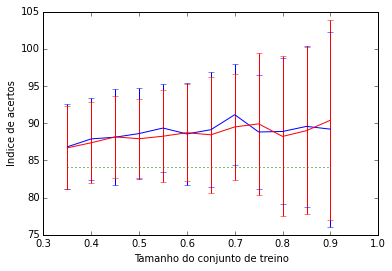

In [7]:
plt.figure();
plt.errorbar(steps, medias, yerr=variancias);
plt.errorbar(steps1, medias1, yerr=variancias1, color='red');
plt.plot(steps, [acertos_nao_supervisionados] * len(steps), ':', color='green')
plt.ylabel('Indice de acertos');
plt.xlabel('Tamanho do conjunto de treino');

Nos deparamos com uma situação interessante. O erro do classificador não-supervisionado é consistentemente maior que o erro da média dos classificadores supervisionados. Ao mesmo tempo, o menor erro obtido pelo caso supervisionado é maior que o erro do caso não-supervisionado.

# Exercícios

1. Desenhe um fluxograma do procedimento de treino não-supervisionado, explicitando as fontes de informação (dados e modelo), e compare-o com o procedimento de treino supervisionado. Discuta possíveis vantagens e desvantagens de cada um deles.

2. Os modelos discutidos neste caderno são chamados *gerativos* porque podem ser usados para gerar dados que seriam típicamente associados a um determinado rótulo. Explique como isso é possível.

3. Um dado importante para resolver o impasse gerado na última figura desta exposição é a probabilidade de que um determinado algoritmo tenha desempenho melhor que outro. Proponha e implemente um procedimento para medir essa probabilidade em nosso problema.